In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat
import statsmodels.api as sm
import scikit_posthocs as sp

pd.set_option('display.max_columns', 9999)

%matplotlib inline

## Data Cleaning

In [2]:
# finding all opioids and nsaids given to patients

opioids = ['hydromorphone','hydrocodone','morphine','oxycodone','oxymorphone','codeine','fentanyl','meperidine',
          'tramadol','carfentanil','percocet','norco']

nsaids = ['acetaminophen','amitriptyline', 'doxepin', 'imipramine', 'desipramine', 'nortriptyline',
         'ibuprofen', 'naproxen', 'diclofenac', 'piroxicam', 'sulindac', 'indomethacin', 'ketorolac', 'meloxicam', 
          'celecoxib', 'ketoprofen', 'oxaprozin', 'toradol', 'valdecoxib', 'bextra', 'rofecoxib', 'vioxx', 'gabapentin', 
          'neurontin', 'cyclobenzaprine', 'duloxetine', 'cymbalta', 'pregabalin', 'lyrica', 'venlafaxine', 'effexor', 
          'tylenol', 'voltaren', 'naprosyn', 'paracetamol', 'aspirin']


def opioids_nsaids (x, li):

    for i in li:
        if i in str(x).lower():
            return 1
        
    return 0

In [3]:
med = pd.read_csv('eicu-collaborative-research-database-2.0/medication.csv.gz')
pts = pd.read_csv('eicu-collaborative-research-database-2.0/patient.csv.gz')
hos = pd.read_csv('eicu-collaborative-research-database-2.0/hospital.csv.gz')

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
med = med[med.drugordercancelled == 'No']

cols_drop = ['medicationid',
             'drugorderoffset',
             'drugivadmixture',
             'drugordercancelled',
             'drughiclseqno',
             'routeadmin',
             'loadingdose',
             'prn',
             'gtc'
            ]

med.drop(columns=cols_drop, inplace=True)

med['opioid'] = med.drugname.apply(lambda x: opioids_nsaids(x, opioids))
med['nsaid'] = med.drugname.apply(lambda x: opioids_nsaids(x, nsaids))

med = med[(med.opioid == 1) | (med.nsaid == 1)]

mg = med.groupby(['patientunitstayid']).agg({'opioid': lambda x:sum(x), 'nsaid': lambda x:sum(x)})
mg[mg != 0] = 1

In [5]:
def op_find (x, arr):
    try:
        return arr['opioid'][x]
    except:
        return np.nan
    
def nsaid_find (x, arr):
    try:
        return arr['nsaid'][x]
    except:
        return np.nan

In [6]:
pts = pts[pts.gender != 'Unknown']
pts = pts[pts.gender != 'Other']

pts['opioid'] = pts['patientunitstayid'].apply(lambda x: op_find(x, mg))
pts['nsaid'] = pts['patientunitstayid'].apply(lambda x: nsaid_find(x, mg))

pts = pd.merge(pts, hos, on=['hospitalid'], how = 'left')

In [7]:
# fill missing values

pts['apacheadmissiondx'].fillna(value = 'N/A', inplace = True)
pts['hospitaladmitsource'].fillna(value = 'Unknown', inplace = True)

def age (x):
    if x == '> 89':
        return 90
    else:
        return int(x)

pts['age'].fillna(value = 0, inplace = True)
pts['age'] = pts['age'].apply(lambda x: age(x))

pts.opioid.fillna(0, inplace = True)
pts.nsaid.fillna(0, inplace = True)

pts.opioid.replace(1.0,True,inplace=True)
pts.opioid.replace(0.0,False,inplace=True)

pts.nsaid.replace(1.0,True,inplace=True)
pts.nsaid.replace(0.0,False,inplace=True)

pts['painmeds'] = pts.opioid|pts.nsaid

In [8]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851,True,True,<100,f,Midwest,True
1,141178,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870,False,True,<100,f,Midwest,True
2,141179,128927,Female,52,Caucasian,60,83,N/A,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870,False,False,<100,f,Midwest,False
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True
4,141196,128943,Male,71,Caucasian,67,109,N/A,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665,True,True,NaN,f,Midwest,True


In [9]:
pts.to_csv('final_patients.csv')

## Plotting
Ethnicity vs. Pain Medication Administration (Either, NSAID Only, Opioid Only)

Text(0, 0.5, 'Proportion Receiving Pain Medications')

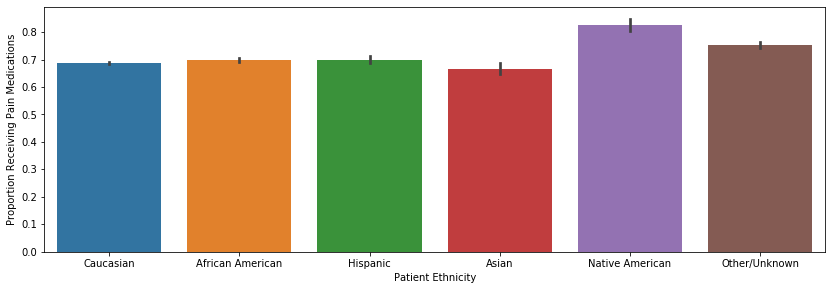

In [80]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='painmeds',data=pts, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Pain Medications')

Text(0, 0.5, 'Proportion Receiving NSAIDs')

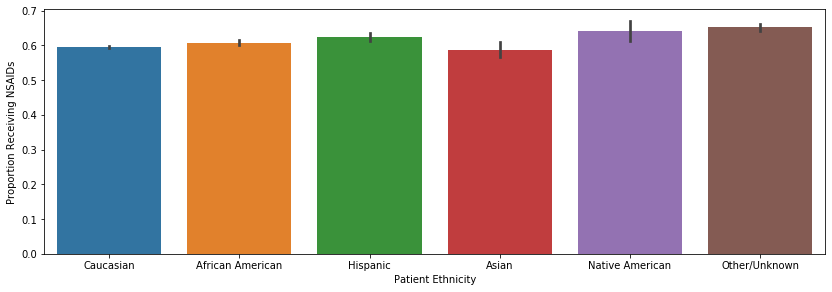

In [81]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='nsaid',data=pts, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving NSAIDs')

Text(0, 0.5, 'Proportion Receiving Opioids')

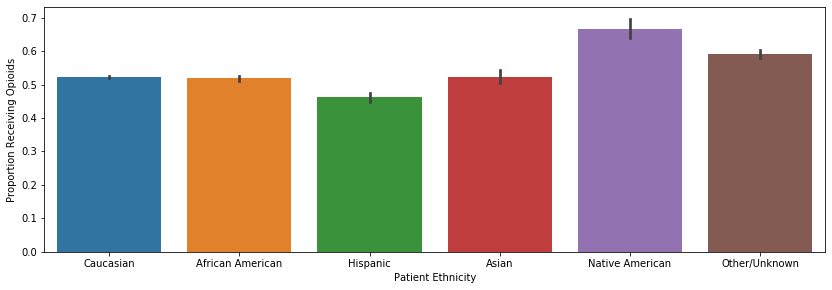

In [82]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='opioid',data=pts, estimator=np.mean)
plt.xlabel('Patient Ethnicity')
plt.ylabel('Proportion Receiving Opioids')

## Checking Significance
Chi-squared testing

### Test 1:
H<sub>0</sub>: Pain medication administration is independent of patient ethnicity.  
H<sub>1</sub>: Pain medication administration is not independent of patient ethnicity.

In [ ]:
ct_eth = pd.crosstab(pts.painmeds, pts.ethnicity)
ct_eth

In [ ]:
c, p, dof, expected = stat.chi2_contingency(ct_eth)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
# We conclude there is a relationship between pain meds and ethnicity.

___
##### Checking between groups

In [ ]:
c_aa_ = ct_eth[['African American','Caucasian']]
c_aa_

In [ ]:
c, p, dof, expected = stat.chi2_contingency(c_aa_)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

___
### Test 2:
H<sub>0</sub>: NSAID administration is independent of patient ethnicity.  
H<sub>1</sub>: NSAID administration is not independent of patient ethnicity.

In [ ]:
ct_ns = pd.crosstab(pts.nsaid, pts.ethnicity)
ct_ns

In [ ]:
c, p, dof, expected = stat.chi2_contingency(ct_ns)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
c_aa_ns = ct_ns[['African American','Caucasian']]
c_aa_ns # do for all groups

In [ ]:
c, p, dof, expected = stat.chi2_contingency(c_aa_ns)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
# We conclude there is a relationship between NSAIDs and ethnicity.

##### Test 3:
H<sub>0</sub>: Opioid administration is independent of patient ethnicity.  
H<sub>1</sub>: Opioid administration is not independent of patient ethnicity.

In [ ]:
ct_op = pd.crosstab(pts.opioid, pts.ethnicity)
ct_op

In [ ]:
c, p, dof, expected = stat.chi2_contingency(ct_op)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
c_aa = ct_op[['African American','Caucasian']]
c_aa # do for all groups

In [ ]:
c, p, dof, expected = stat.chi2_contingency(c_aa)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
# We conclude there is a relationship between Opioids and ethnicity.

___
### Morphine Equivalence Analysis

In [35]:
opi = pd.read_csv('opioids_final.csv')
opi = pd.merge(opi, pts, on=['patientunitstayid'], how = 'left')

In [37]:
opi_stat = opi[['patientunitstayid','mme_per_day']]
#opi_stat.fillna(value='Other/Unknown', inplace=True)

opi_stat.head()

,patientunitstayid,mme_per_day
0,141194,12.8
1,141203,192.0
2,141229,192.0
3,141244,192.0
4,141260,30.0


In [ ]:
plt.figure(figsize=(14, 4.5))
sns.barplot(x='ethnicity',y='mme_per_day',data=opi_stat, estimator=np.mean)
plt.xlabel('Ethnicity')
plt.ylabel('MME per Day')

In [ ]:
# Testing for Normal Distribution

opi_stat_c = list(opi_stat[opi_stat.ethnicity == 'Caucasian'].mme_per_day)
opi_stat_aa = list(opi_stat[opi_stat.ethnicity == 'African American'].mme_per_day)
opi_stat_a = list(opi_stat[opi_stat.ethnicity == 'Asian'].mme_per_day)
opi_stat_h = list(opi_stat[opi_stat.ethnicity == 'Hispanic'].mme_per_day)
opi_stat_na = list(opi_stat[opi_stat.ethnicity == 'Native American'].mme_per_day)
opi_stat_o = list(opi_stat[opi_stat.ethnicity == 'Other/Unknown'].mme_per_day)

k_c, p_c = stat.kstest(opi_stat_c, 'norm')
k_aa, p_aa = stat.kstest(opi_stat_aa, 'norm')
k_a, p_a = stat.kstest(opi_stat_a, 'norm')
k_h, p_h = stat.kstest(opi_stat_h, 'norm')
k_na, p_na = stat.kstest(opi_stat_na, 'norm')
k_o, p_o = stat.kstest(opi_stat_o, 'norm')

print('Caucasian: k-value:', k_c, 'p-value:', p_c)
print('African America: k-value:', k_aa, 'p-value:', p_aa)
print('Asian: k-value:', k_a, 'p-value:', p_a)
print('Hispanic: k-value:', k_h, 'p-value:', p_h)
print('Native American: k-value:', k_na, 'p-value:', p_na)
print('Other: k-value:', k_o, 'p-value:', p_o)

In [ ]:
# Non-normal distributions, using non-parametric Kruskal-Wallis H-test

stat.kruskal(opi_stat_c,opi_stat_aa,opi_stat_a,opi_stat_h,opi_stat_na,opi_stat_o)

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Multiple pairwise comparison (Tukey HSD) - whats the nonparametric equivalent?

m_comp = pairwise_tukeyhsd(endog=opi_stat['mme_per_day'], groups=opi_stat['ethnicity'], alpha=0.05)
m_comp.summary()

In [ ]:
nemenyi = sp.posthoc_nemenyi(opi_stat, 'mme_per_day', 'ethnicity')
nemenyi

In [ ]:
# Bonferroni correction

pvals = [] # grab pvals from nemenyi df above by columns

for i in nemenyi.columns:
    pvals = pvals + list(nemenyi[i])

from statsmodels.stats.multitest import multipletests

p_adjusted = multipletests(pvals, alpha=0.05, method='bonferroni')

In [ ]:
print('Corrected alpha for Bonferroni method: ', p_adjusted[3])

In [ ]:
group1 = []
group2 = []

for col in nemenyi.columns:
    for row in nemenyi.index:
        group1.append(col)
        group2.append(row)

In [ ]:
d = {'group1': group1, 'group2': group2, 'p_vals': p_adjusted[1], 'reject': p_adjusted[0]}

nemenyi_comp = pd.DataFrame(data=d)

In [ ]:
nemenyi_comp

In [ ]:
# Still need to remove duplicates 
# (i.e., group1 = African American, group2 = Caucasian &  group1 = Caucasian, group2 = African American)

### Chi Square for Specific Groups

In [ ]:
opi_eth = pd.get_dummies(pts, columns=['ethnicity'])

In [ ]:
opi_eth.head()

In [ ]:
african_american = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_African American'])
african_american

In [ ]:
c, p, dof, expected = stat.chi2_contingency(african_american)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
asian = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Asian'])
asian

In [ ]:
c, p, dof, expected = stat.chi2_contingency(asian)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
caucasian = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Caucasian'])
caucasian

In [ ]:
c, p, dof, expected = stat.chi2_contingency(caucasian)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
hispanic = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Hispanic'])
hispanic

In [ ]:
c, p, dof, expected = stat.chi2_contingency(hispanic)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
namerican = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Native American'])
namerican

In [ ]:
c, p, dof, expected = stat.chi2_contingency(namerican)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

In [ ]:
other = pd.crosstab(opi_eth.opioid, opi_eth['ethnicity_Other/Unknown'])
other

In [ ]:
c, p, dof, expected = stat.chi2_contingency(other)

print('Pearson Chi-Square: ', c)
print('p-value: ', p)

___
### Multivariate Analysis

In [13]:
apache = pd.read_csv('eicu-collaborative-research-database-2.0/apachePatientResult.csv.gz')

apache = apache[apache['apacheversion']=='IV']
apache_scores = apache[['patientunitstayid','apachescore','actualventdays']]
pts = pd.merge(pts, apache_scores, on=['patientunitstayid'], how = 'right')

In [ ]:
#vent = pd.read_csv('eicu-collaborative-research-database-2.0/respiratoryCare.csv.gz')

#vent['vent_duration'] = vent['ventendoffset'] - vent['ventstartoffset']
#vent['vent_duration'] = abs(vent['vent_duration'])
#ventdur = vent[['patientunitstayid','vent_duration']]

#vent_dur = ventdur.groupby('patientunitstayid')['vent_duration'].sum()/1440
#x = pd.DataFrame(vent_dur)

#pts = pd.merge(pts, x, on=['patientunitstayid'], how = 'left')

In [15]:
pts.actualventdays.fillna(value=0, inplace=True)

In [16]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,opioid,nsaid,numbedscategory,teachingstatus,region,painmeds,apachescore,actualventdays
0,141168,128919.0,Female,70.0,Caucasian,59.0,91.0,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0.0,Direct Admit,2015.0,03:50:00,3596.0,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1.0,admit,84.3,85.8,03:50:00,3596.0,Death,Expired,002-34851,True,True,<100,f,Midwest,True,65,0.0
1,141194,128941.0,Male,68.0,Caucasian,73.0,92.0,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780.0,Floor,2015.0,23:30:00,12492.0,Home,Alive,CTICU,07:18:00,Floor,1.0,admit,73.9,76.7,15:31:00,4813.0,Floor,Alive,002-5276,True,True,>= 500,t,Midwest,True,70,0.0
2,141203,128948.0,Female,77.0,Caucasian,66.0,90.0,"Arrest, respiratory (without cardiac arrest)",160.0,22:23:00,-1336.0,Floor,2014.0,16:22:00,4063.0,Other External,Alive,Med-Surg ICU,20:39:00,Floor,1.0,admit,70.2,70.3,03:48:00,1869.0,Floor,Alive,002-23234,True,True,100 - 249,f,Midwest,True,90,2.0
3,141208,128952.0,Female,25.0,Caucasian,73.0,93.0,"Overdose, sedatives, hypnotics, antipsychotics...",172.7,11:23:00,-1.0,Emergency Department,2015.0,21:30:00,606.0,Other Hospital,Alive,Med-Surg ICU,11:24:00,Emergency Department,1.0,admit,95.3,95.3,23:24:00,720.0,Home,Alive,002-34521,False,True,>= 500,t,Midwest,True,17,0.0
4,141227,128968.0,Male,82.0,Caucasian,60.0,83.0,"Sepsis, pulmonary",185.4,19:19:00,-1004.0,Floor,2015.0,16:35:00,1712.0,Other Hospital,Alive,Med-Surg ICU,12:03:00,Floor,1.0,admit,82.2,82.2,15:35:00,1652.0,Other Hospital,Alive,002-21459,True,True,<100,f,Midwest,True,100,2.0


In [17]:
pts_final = pts[['patientunitstayid','gender', 'age', 'ethnicity', 'teachingstatus', 'actualventdays', 'painmeds', 'opioid', 'nsaid']]

In [18]:
pts_final.to_csv('final_patients.csv')

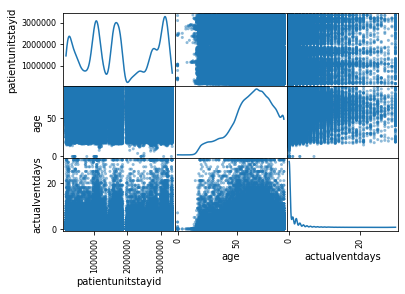

In [19]:
from pandas.plotting import scatter_matrix

scatter_matrix(pts_final, diagonal="kde")
plt.show()

In [38]:
pts_final = pd.merge(pts_final, opi_stat, on=['patientunitstayid'], how = 'left')
pts_final.head()

,patientunitstayid,gender,age,ethnicity,teachingstatus,actualventdays,painmeds,opioid,nsaid,mme_per_day
0,141168,Female,70.0,Caucasian,f,0.0,True,True,True,1728.0
1,141194,Male,68.0,Caucasian,t,0.0,True,True,True,12.8
2,141194,Male,68.0,Caucasian,t,0.0,True,True,True,230.4
3,141194,Male,68.0,Caucasian,t,0.0,True,True,True,288.0
4,141194,Male,68.0,Caucasian,t,0.0,True,True,True,30.0


In [40]:
pts_final.mme_per_day.fillna(0.0,inplace=True)

In [42]:
pts_final.dropna(inplace=True)

In [45]:
pts_final["painmeds"] = pts_final["painmeds"].astype(int)
pts_final["opioid"] = pts_final["opioid"].astype(int)
pts_final["nsaid"] = pts_final["nsaid"].astype(int)

In [48]:
pts_final = pd.get_dummies(pts_final, columns = ['gender','teachingstatus'], drop_first = True)
pts_final = pd.get_dummies(pts_final, columns = ['ethnicity'], drop_first = False)

In [57]:
pts_final.to_csv('patients_to_log.csv')

In [118]:
def logreg_df(df, norm_cols, drop_cols, y_col, drop=False, reg=0):
    """
    df (string): CSV path.
    cat_cols (list): categorical columns to one-hot-encode.
    norm_cols (list): columns in df to normalize.
    drop_cols (list): columns to drop.
    y_col (string): variable of interest.
    """
    
    #df = pd.read_csv('df')
    #df = pd.get_dummies(df, columns = cat_cols, drop_first = drop)
    
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.datasets import load_iris
    
    df[norm_cols] = MinMaxScaler().fit_transform(df[norm_cols])
    
    if reg == 0:
        X = df.drop(columns = drop_cols)
        y = df[y_col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
        
        log = LogisticRegression(penalty='l1',solver='liblinear')
        res = log.fit(X, y)
        
        print(res.)
        print(res.coef_, res.intercept_)
        
        logit_model = sm.Logit(y, X)
        result = logit_model.fit_regularized()

        print(result.summary2())
        
    elif reg == 1:
        X = df.drop(columns = drop_cols)
        y = df[y_col]
        X = sm.add_constant(X)
        
        ols_model = sm.OLS(y,X)
        result = ols_model.fit()
        
        print(result.summary())
    
    return result

#### Painmeds by Ethnicity

In [120]:
eth = ['ethnicity_Caucasian', 'ethnicity_African American', 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

for i in eth:
    norm = ['actualventdays','age']
    dp = ['opioid', 'nsaid', 'patientunitstayid','painmeds',i, 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown', 'age', 'actualventdays', 'mme_per_day',
         'gender_Male', 'teachingstatus_t']
    
    print("Compared to ", i)
    logreg_df(pts_final, norm, dp, 'painmeds')

Compared to  ethnicity_Caucasian
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6653912604741101
            Iterations: 9
            Function evaluations: 9
            Gradient evaluations: 9
                             Results: Logit
Model:                Logit              Pseudo R-squared:   -0.632     
Dependent Variable:   painmeds           AIC:                424863.6353
Date:                 2021-03-14 22:25   BIC:                424874.3090
No. Observations:     319257             Log-Likelihood:     -2.1243e+05
Df Model:             0                  LL-Null:            -1.3017e+05
Df Residuals:         319256             LLR p-value:        nan        
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       9.0000                                            
------------------------------------------------------------------------
                           Coef.  Std.Err.    z     P>|z| 

In [ ]:
# In the above Caucasian baseline, there was no significance with African Americans, so why is it not both ways?

In [ ]:
# basically the above is saying compared to caucasians, hispanic and native american are signiciant 
# - both are more likely to receive pain meds

#### Ethnicity vs. Receiving Opioids

In [95]:
eth = ['ethnicity_Caucasian', 'ethnicity_African American', 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

for i in eth:
    norm = ['actualventdays','age']
    dp = ['patientunitstayid','painmeds','opioid', i]
    
    print("Compared to ", i)
    logreg_df(pts_final, norm, dp, 'opioid', reg=0)

Compared to  ethnicity_Caucasian
Optimization terminated successfully.
         Current function value: 0.351039
         Iterations 10
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.332      
Dependent Variable:    opioid              AIC:                 224165.5533
Date:                  2021-03-14 22:07    BIC:                 224282.9646
No. Observations:      319257              Log-Likelihood:      -1.1207e+05
Df Model:              10                  LL-Null:             -1.6779e+05
Df Residuals:          319246              LLR p-value:         0.0000     
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        10.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------

#### Ethnicity vs. MME

In [92]:
eth = ['ethnicity_Caucasian', 'ethnicity_African American', 'ethnicity_Asian',
      'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

for i in eth:
    norm = ['actualventdays','age']
    dp = ['mme_per_day','patientunitstayid','painmeds', i]
    
    print("Compared to ", i)
    logreg_df(pts_final, norm, dp, 'mme_per_day', reg=1)

Compared to  ethnicity_Caucasian


/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            mme_per_day   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     643.2
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:36:13   Log-Likelihood:            -2.1144e+06
No. Observations:              319257   AIC:                         4.229e+06
Df Residuals:                  319245   BIC:                         4.229e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            mme_per_day   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     643.2
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:36:13   Log-Likelihood:            -2.1144e+06
No. Observations:              319257   AIC:                         4.229e+06
Df Residuals:                  319245   BIC:                         4.229e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            mme_per_day   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     643.2
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:36:13   Log-Likelihood:            -2.1144e+06
No. Observations:              319257   AIC:                         4.229e+06
Df Residuals:                  319245   BIC:                         4.229e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            mme_per_day   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     643.2
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:36:13   Log-Likelihood:            -2.1144e+06
No. Observations:              319257   AIC:                         4.229e+06
Df Residuals:                  319245   BIC:                         4.229e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            mme_per_day   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     643.2
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:36:14   Log-Likelihood:            -2.1144e+06
No. Observations:              319257   AIC:                         4.229e+06
Df Residuals:                  319245   BIC:                         4.229e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:            mme_per_day   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     643.2
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:36:14   Log-Likelihood:            -2.1144e+06
No. Observations:              319257   AIC:                         4.229e+06
Df Residuals:                  319245   BIC:                         4.229e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
# fake patient with figure

In [ ]:
# https://towardsdatascience.com/multiple-imputation-with-random-forests-in-python-dec83c0ac55b